In [2]:
import neo
import h5py
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

import quantities as pq
from elephant.gpfa import GPFA

In [3]:
# ---- Convert to neo.SpikeTrains ---- #
def array_to_spiketrains(array, bin_size):
    """Convert B x T x N spiking array to list of list of SpikeTrains"""
    stList = []

    for trial in range(len(array)):
        trialList = []
        for channel in range(array.shape[2]):
            times = np.nonzero(array[trial, :, channel])[0]
            counts = array[trial, times, channel].astype(int)
            times = np.repeat(times, counts)
            st = neo.SpikeTrain(times*bin_size*pq.ms, t_stop=array.shape[1]*bin_size*pq.ms)
            trialList.append(st)
        stList.append(trialList)
    return stList

In [4]:
# load and prepare data
data = h5py.File('data/poisson_obs.h5')

Y = np.array(data['Y'])
X = np.array(data['X'])
C = np.array(data['C'])
b = np.array(data['bias'])

# setup parameters
n_trials = 100
bin_size_ms = 5
time_delta = bin_size_ms * 1e-3

n_latents = X.shape[2]
n_neurons = Y.shape[2]
n_time_bins = Y.shape[1]

Y = Y[:n_trials]
X = X[:n_trials]
Y_st_train = array_to_spiketrains(Y, bin_size_ms)

In [6]:
# ---- Run GPFA ---- #
gpfa = GPFA(bin_size=(bin_size_ms * pq.ms), x_dim=n_latents)
gpfa_val_result = gpfa.fit_transform(Y_st_train)

length_scales = gpfa.params_estimated['gamma']

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 380 EM iterations.)


X_hat shape: (50000, 2)


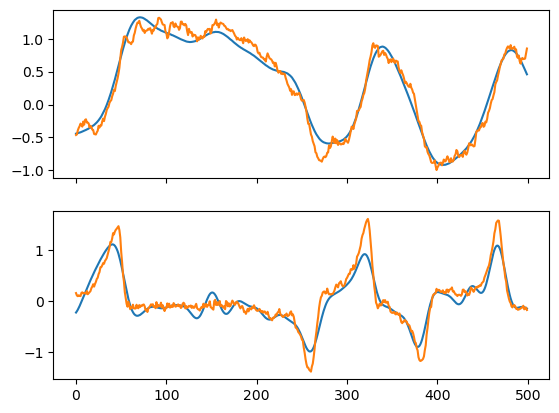

In [7]:
# regress to account for invariance
X_hat = rearrange(np.stack(gpfa_val_result, 0), 'trials lat time -> (trials time) lat')
S = np.linalg.pinv(X_hat) @ X.reshape(n_trials * n_time_bins, n_latents)
X_hat_tilde = X_hat @ S
X_hat_tilde = X_hat_tilde.reshape(n_trials, n_time_bins, n_latents)

# Plot
fig, axs = plt.subplots(2, 1, sharex='all')
print(f'X_hat shape: {X_hat.shape}')
axs[0].plot(X_hat_tilde[0, :, 0])
axs[0].plot(X[0, :, 0])
axs[1].plot(X_hat_tilde[0, :, 1])
axs[1].plot(X[0, :, 1])
plt.show()

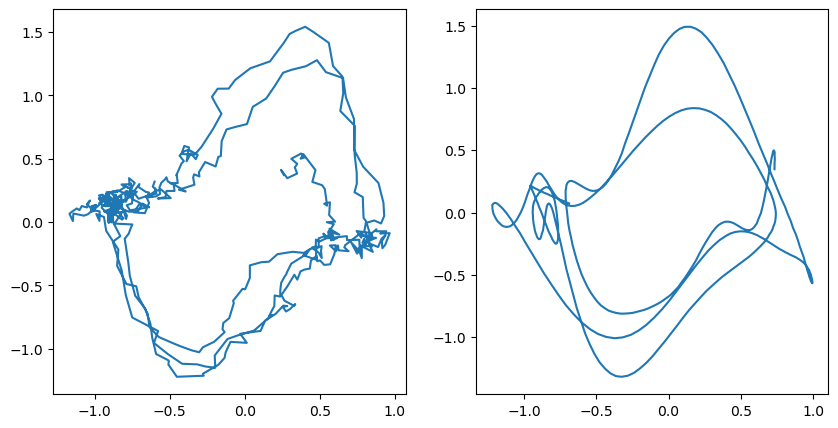

In [12]:
# plot the true and inferred latents of trial 0
trial_num = 1
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(10,5))
_= ax0.plot(X[trial_num,:,0], X[trial_num,:,1])
_= ax1.plot(X_hat_tilde[trial_num,:,0], X_hat_tilde[trial_num,:,1])